# Now That's What I Call Kaggle
In this kernel we will be studying the last 61 iterations of Now That's what I call Music and their tracks to see what interesting details we can extract for them and maybe even infer a few things about the maintream music taste in the USA since 1998.

In [1]:
%matplotlib inline
# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

## Data loading

In [2]:
# loading the data
df = pd.read_csv('Now_with_Spotify_Final.csv')
df.head()

,speechiness,key,time_signature,liveness,loudness,duration_ms,danceability,duration,valence,acousticness,spotify_id,volume_number,energy,tempo,instrumentalness,mode,number,artist,title
0,0.1400,4.0,4.0,0.0521,-6.055,267267.0,0.891,266,0.820,0.20200,spotify:track:1AWQoqb9bSvzTjaLralEkT,13,0.714,100.972,0.000234,0.0,1,Justin Timberlake,Rock Your Body
1,0.0555,10.0,4.0,0.0853,-5.416,222040.0,0.741,221,0.362,0.03980,spotify:track:7AUfOfYTfiHhgg2Pw1aTpw,13,0.575,93.992,0.127000,0.0,2,Jennifer Lopez,I'm Glad
2,0.2160,3.0,4.0,0.0504,-6.562,205000.0,0.676,203,0.533,0.02410,spotify:track:5UrbZaqIsclBE9IAcnG43M,13,0.561,89.947,0.000000,0.0,3,B2K,Girlfriend
3,0.3010,1.0,4.0,0.0518,-4.857,280053.0,0.691,229,0.877,0.01860,spotify:track:6JW8DqCEOWaj8z5AIx4ugf,13,0.858,92.773,0.000000,1.0,4,Jay-Z,Excuse Me Miss
4,0.2440,5.0,4.0,0.0908,-7.114,268333.0,0.573,218,0.578,0.00029,spotify:track:5DLkPmyenHS2uJclC8nPCA,13,0.606,176.449,0.000000,0.0,5,Ginuwine featuring Baby,Hell Yeah


## Exploration

### Release Year
If we look at the [wikipedia page](https://en.wikipedia.org/wiki/Now_That%27s_What_I_Call_Music!_discography), we can see all the albums and their relese dates. This means we can actually infer the release year.

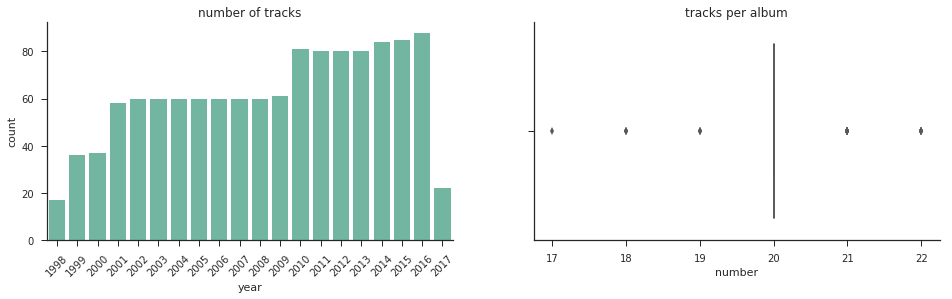

In [3]:
release_years = [1998, 1999, 1999, 2000, 2000, 2001, 2001, 2001, 2002, 2002, 2002, 2003, 2003, 2003,
                 2004, 2004, 2004, 2005, 2005, 2005, 2006, 2006, 2006, 2007, 2007, 2007, 2008, 2008, 
                 2008, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2012, 2012, 
                 2012, 2012, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 
                 2016, 2016, 2016, 2016, 2017]
df['year'] = df['volume_number'].apply(lambda x: release_years[x - 1])  # 0 indexed

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
sns.countplot(data=df, x='year', color=sns.color_palette('Set2')[0], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_title('number of tracks')
sns.despine(ax=ax)


ax = fig.add_subplot(122)
sns.boxplot(data=df.groupby('volume_number').agg('count'), x='year', color=sns.color_palette('Set2')[0], ax=ax)
ax.set_title('tracks per album')
ax.set_xlabel('number')
sns.despine(ax=ax)

Looking at graph above we see that although, different numbers of albums were published each year, allmost all of them have 

### Songs per artist
Now that we have the data, we can do some exploration on it. Why don't we see what songs have the most main artists and featured verses. 

### Artsts featuring stats
Looking at the data we can also see that many of these songs have more than one artist. Looking over then we can safely assume that the format in which the artist is written is the following:

    main_artist_1[, main_artist_2[, ...[ and main_artist_n]]] [featuring feat_artist_1[, feat_artist_2[, ...[ and feat_artist_n]]] 
    
This means we can expand each record into several row, one for each artists, that includes the wether they were the main artists or the featured artists for that song. From this we could gather some interesting data about performances.

We will start by splitting the data ccording to the seprators we described above into featured and main artists, then we will be splitting those too into individual artists.

In [4]:
# split the artists into mains and features
artists = df['artist'].str.split(r'\s*featuring\s*').apply(pd.Series)

# get the artists
main_artist = artists[0].str.split(r'(\s+and\s+)|,').apply(pd.Series).stack()
main_df = pd.DataFrame(data={'artist_name': main_artist, 'featuring': False})
main_df.index = main_df.index.droplevel(-1)

# get the featuring artists
feat_artist = artists[1].dropna().str.split(r'\s+and\s+|,').apply(pd.Series).stack()
feat_df = pd.DataFrame(data={'artist_name': feat_artist, 'featuring': True})
feat_df.index = feat_df.index.droplevel(-1)

# join the results
artist_df = pd.concat([df.join(main_df, how='inner'), df.join(feat_df, how='inner')], axis='rows')

# strip the spaces and drop the redundant 'and's
artist_df['artist_name'] = artist_df['artist_name'].str.strip()
artist_df = artist_df[artist_df['artist_name'] != 'and']  #  split fails sometimes

In [5]:
# group by song and 
feat_stats = artist_df.groupby([artist_df.index, 'featuring'], ).agg({'title': ['count', 'first'], 'artist': 'first', 'year': 'first'})
feat_stats = feat_stats.unstack().T.reset_index(drop=True).T
feat_stats = feat_stats.drop([3, 5, 7], axis='columns').fillna(0)  # some songs just don't have any features
feat_stats.columns = ['main', 'feat', 'title', 'artist', 'year']
feat_stats['total'] = feat_stats['main'] + feat_stats['feat']
df = df.join(feat_stats[['main', 'feat', 'total']])  #  add them to the input dataframe

In [6]:
feat_stats[['main', 'feat', 'total']].apply(pd.value_counts, axis='rows').fillna(0)

,main,feat,total
0.0,0.0,977.0,0.0
1.0,1205.0,222.0,956.0
2.0,22.0,25.0,238.0
3.0,2.0,5.0,30.0
4.0,0.0,0.0,5.0


In [7]:
feat_stats.sort_values('total', ascending=False).head(7)

,main,feat,title,artist,year,total
800,1.0,3.0,Give Me Everything,"Pitbull featuring Ne-Yo, Afrojack and Nayer",2011.0,4.0
243,1.0,3.0,Bailando,"Enrique Iglesias featuring Sean Paul, Descemer...",2014.0,4.0
722,1.0,3.0,Hey Mama,"David Guetta featuring Nicki Minaj, Bebe Rexha...",2015.0,4.0
704,1.0,3.0,I Think They Like Me (Remix),"Dem Franchize Boyz featuring Jermaine Dupri, D...",2005.0,4.0
1162,1.0,3.0,Strangers,"Seven Lions featuring Myon, Shane 54 and Tove Lo",2014.0,4.0
1204,1.0,2.0,Give Me Your Love,Sigala featuring John Newman and Nile Rodgers,2016.0,3.0
799,1.0,2.0,Party Rock Anthem,LMFAO featuring Lauren Bennett and GoonRock,2011.0,3.0


Wow. Lookin over the data we can see that most of the songs have 1 or 2 artists credited, but a few songs(7 to be exact) have a whopping 4 artists on the track. 

### Colabs vs year
Next we will be trying to see if there is some correlation between the number of artists and year.

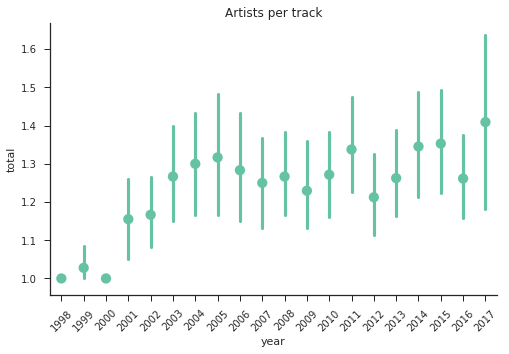

In [8]:
plt.figure(figsize=(8,5))
g = sns.pointplot(data=df[['year', 'total']], y='total', x='year', join=False)
plt.xticks(rotation=45)
plt.title('Artists per track')
sns.despine()

As we can see, there is a clear increase in the average number average number of artists on a track over time. This year is not only the one with the greatest average, but also the one with the most variance. This is probably due to the fact that most artists prefer to release their own albums, as we can see from the frequency table. However, one might notice that out the first 7 song with the most artists, 4 have been release after 2010.

### Featureability
Speaking of which. Now that we have al the artists, their published songs and those on which they are featured, we can see the artists that have the most songs and those who are the most featured.

In [9]:
# number of personal songs and collaborations
artist_stats = artist_df.groupby('artist_name').apply(lambda grp: pd.Series({
    'own_songs': (~grp['featuring']).sum(),
    'features': grp['featuring'].sum()
}))
artist_stats['total_songs'] = artist_stats['own_songs'] + artist_stats['features']
artist_stats['featurability'] = artist_stats['features'] / artist_stats['total_songs']

# add musical metric stats
metric_cols = ['speechiness', 'key', 'time_signature', 'liveness', 'loudness',
    'duration_ms', 'danceability', 'duration', 'valence', 'acousticness',
    'spotify_id', 'volume_number', 'energy', 'tempo', 'instrumentalness',
    'mode']

# we just use the mean for these ones
artist_music_stats = artist_df.groupby('artist_name')[metric_cols].mean()
artist_stats = artist_stats.join(artist_music_stats, how='left')

In this next plot we will be exploring the distributions of the number of songs each artists produces. More specifically, we will be loooking into their own songs, their features and the total.

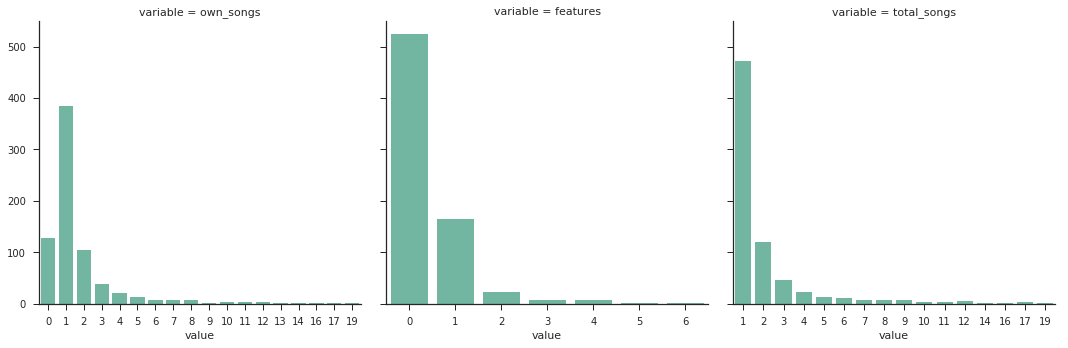

In [10]:
# data needs to be wrangled a bit to use it with seaborns grids
plot_df = (artist_stats[['own_songs', 'features', 'total_songs']]
    .stack()
    .reset_index()
    .rename(columns={'level_1': 'variable', 0: 'value'}))

# plot it sharex is disabled so the xlabels aren't locked ogether
g = sns.FacetGrid(data=plot_df, col='variable', size=5, sharex=False)
g.map(sns.countplot, 'value');

As we can see, obviously, all artists have performed in at least one song, however apparently as many artists as there are with two own songs have gotten to the lists only through colabs. Also, as we can see, although few, there are artists with as many as 19 songs whereas none of them appear on other peoples' songs more than 6 times.

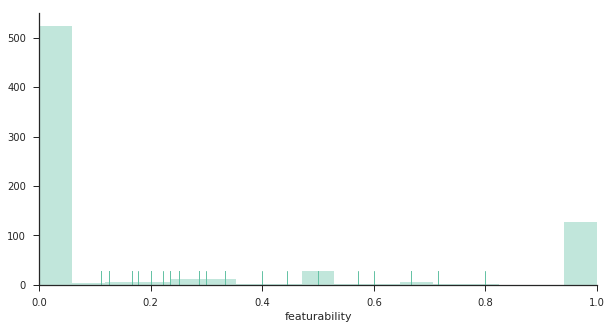

In [11]:
plt.figure(figsize=(10, 5))
sns.distplot(artist_stats['featurability'], hist=True, rug=True, kde=False)
plt.xlim(0, 1)
sns.despine()

When it comes to the success of their personal songs vs the songs they were featured on, it appears that most artists succede with their own creations, with a few in the middle, having eaqually many colabs and personal compositions. However, a few artists seem to have found themselves a niche where they only appeare on other songs. 

Now to look at the top. We will begin with the most sucessful artists, those who have got on the album the greates number of times.

In [12]:
artist_stats['total_songs'].sort_values(ascending=False).head(20)

artist_name
Britney Spears         19
Katy Perry             17
Chris Brown            17
Justin Timberlake      17
Pitbull                17
Taylor Swift           16
Rihanna                16
Bruno Mars             14
Nickelback             12
Ne-Yo                  12
The Black Eyed Peas    12
Pink                   12
Kelly Clarkson         12
Lady Gaga              11
Backstreet Boys        11
Maroon 5               11
T-Pain                 10
Keith Urban            10
Ariana Grande          10
Usher                  10
Name: total_songs, dtype: int64

Here, in the top 20, we can see a large gap emerging. Britney Spears is in the top with 19 songs, almost twice as many as T-Pain and the others who are on the 17th position.

In [13]:
artist_stats['own_songs'].sort_values(ascending=False).head(20)

artist_name
Britney Spears         19
Katy Perry             17
Taylor Swift           16
Rihanna                14
Pitbull                14
Justin Timberlake      13
Chris Brown            13
The Black Eyed Peas    12
Pink                   12
Kelly Clarkson         12
Nickelback             12
Maroon 5               11
Lady Gaga              11
Backstreet Boys        11
Bruno Mars             10
Ariana Grande          10
Keith Urban            10
Jennifer Lopez          9
Coldplay                9
OneRepublic             8
Name: own_songs, dtype: int64

As for songs of their own, the leaderboard shifts a bit, but the numbers are fairly similar.

In [14]:
artist_stats['featurability'].sort_values(ascending=False).head(10)

artist_name
will.i.am                   1.0
City Spud                   1.0
Charlay                     1.0
Charlie Wilson              1.0
Pusha T                     1.0
Cherine Anderson            1.0
Popcaan                     1.0
Pharrell                    1.0
Perla Cruz & Russell Lee    1.0
Peanut                      1.0
Name: featurability, dtype: float64

In [15]:
artist_stats['features'].sort_values(ascending=False).head(10)

artist_name
T-Pain               6
Nicki Minaj          6
Akon                 5
Lil Wayne            5
Sean Paul            4
T.I.                 4
Justin Timberlake    4
Ne-Yo                4
Ludacris             4
Chris Brown          4
Name: features, dtype: int64

There are over 100 artists who got to the charts almost solely as featured guests and here we can see 10 of them and also some of those who have the most features overall.